In [105]:
import warnings
import sklearn
import streamlit as st
import pandas as pd
import numpy as np
import re

path='./dataset/'

df = pd.read_csv(path+"labeled_data.csv")
df['tweet'] = df['tweet'].apply(lambda tweet: re.sub('[^A-Za-z]+', ' ', tweet.lower()))
df['tweet']

0         rt mayasolovely as a woman you shouldn t comp...
1         rt mleew boy dats cold tyga dwn bad for cuffi...
2         rt urkindofbrand dawg rt sbaby life you ever ...
3         rt c g anderson viva based she look like a tr...
4         rt shenikaroberts the shit you hear about me ...
                               ...                        
24778    you s a muthaf in lie lifeasking pearls corey ...
24779    you ve gone and broke the wrong heart baby and...
24780    young buck wanna eat dat nigguh like i aint fu...
24781                youu got wild bitches tellin you lies
24782     ruffled ntac eileen dahlia beautiful color co...
Name: tweet, Length: 24783, dtype: object

In [88]:
from sklearn import preprocessing
lb = preprocessing.LabelEncoder()
y = df['class']

In [89]:
X = df.drop('class', axis=1)
X.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,tweet
0,0,3,0,0,3,rt mayasolovely as a woman you shouldn t comp...
1,1,3,0,3,0,rt mleew boy dats cold tyga dwn bad for cuffi...
2,2,3,0,3,0,rt urkindofbrand dawg rt sbaby life you ever ...
3,3,3,0,2,1,rt c g anderson viva based she look like a tr...
4,4,6,0,6,0,rt shenikaroberts the shit you hear about me ...


In [90]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)

<AxesSubplot:>

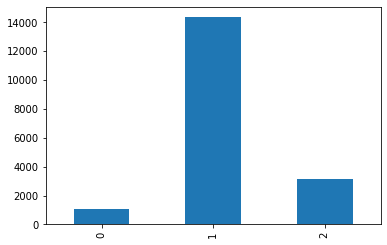

In [91]:
y_train.value_counts().plot(kind='bar')

In [92]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(strip_accents='ascii', token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b',
                             lowercase=True, stop_words='english')
X_train_cv = cv.fit_transform(X_train.tweet)
X_test_cv = cv.transform(X_test.tweet)
X_train_cv

<18587x28759 sparse matrix of type '<class 'numpy.int64'>'
	with 162438 stored elements in Compressed Sparse Row format>

In [93]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
cols = ['hate_speech', 'offensive_language', 'neither']
X_train_sc = scaler.fit_transform(X_train[cols])
X_test_sc = scaler.transform(X_test[cols])

In [94]:
import scipy.sparse as sp
train_count = sp.csr_matrix(X_train_cv)
train_num = sp.csr_matrix(X_train_sc)
X_train = sp.hstack([train_count, train_num])

test_count = sp.csr_matrix(X_test_cv)
test_num = sp.csr_matrix(X_test_sc)
X_test = sp.hstack([test_count, test_num])

# Save top words for training set
word_freq_df = pd.DataFrame(X_train_cv.toarray(), columns=cv.get_feature_names())

In [95]:
#TOP 5
pd.DataFrame(word_freq_df.sum()).sort_values(0, ascending=False).head(5)

,0
bitch,6229
rt,5696
t,5220
bitches,2310
http,2171


In [82]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
predictions

array([1, 1, 1, ..., 1, 2, 1], dtype=int64)

In [97]:
# Plot scores and make a confusion matrix for non-hate/hate predictions

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
n_classes = 2
cm = confusion_matrix(y_test, predictions, labels=range(n_classes))

print(f'Number of samples to classify: {len(X_test.toarray())}\n')
print(f'Accuracy score: {accuracy_score(y_test, predictions)}')
#print(f'Precision score: {precision_score(y_test, predictions)}')
#print(f'Recall score: {recall_score(y_test, predictions)}\n')
print(f'Confusion matrix: \n{cm}')

Number of samples to classify: 6196

Accuracy score: 0.7030342156229825
Confusion matrix: 
[[   0  312]
 [  16 4223]]


In [110]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from stop_words import get_stop_words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier

clf = make_pipeline(
    TfidfVectorizer(stop_words=get_stop_words('en')),
    OneVsRestClassifier(SVC(kernel='linear', probability=True))
)

clf = clf.fit(X=df['tweet'], y=df['class'])

C:\Program Files\Python38\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'can', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [111]:
text = "I hate you, please die!"
clf.predict_proba([text])[0]


array([0.64649707, 0.13829898, 0.21520395])

In [112]:
import joblib

model_filename = "hatespeech.joblib.z"
joblib.dump((clf), model_filename)

['hatespeech.joblib.z']

In [115]:
clf2 = joblib.load(model_filename)
clf2

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(stop_words=['a', 'about', 'above', 'after',
                                             'again', 'against', 'all', 'am',
                                             'an', 'and', 'any', 'are',
                                             "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', "can't",
                                             'cannot', 'could', "couldn't",
                                             'did', ...])),
                ('onevsrestclassifier',
                 OneVsRestClassifier(estimator=SVC(kernel='linear',
                                                   probability=True)))])